## AGN Structure Function Error ##

This metric, contributed by Weixiang Yu, estimates the error in the structure function of an AGN, based on the timing and depth of a series of observations. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [4]:
opsim_file = get_baseline()
runName = os.path.split(opsim_file)[-1].replace('.db', '')
print(f'{runName} : {opsim_file}')

baseline_v2.1_10yrs : /Users/lynnej/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db


In [5]:
# Set up output directories
outDir = 'test_agn'
resultsDb = maf.ResultsDb(outDir)

In [6]:
# Connect to database
opsdb = maf.OpsimDatabase(opsim_file)

In [7]:
# The metric is intended to run per filter
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')

# And in each filter, the 'test' magnitude for the AGN is intended to be about 0.5 mags above the 
# median single-visit limiting magnitudes of all visits in the current baseline

# We could look those up, or calculate them here ..

visit_depth = {}
for f in filterlist:
    m = maf.MedianMetric(col='fiveSigmaDepth')
    sql = f'filter == "{f}"'
    allvisits_slicer = maf.UniSlicer()
    visit_depth[f] = maf.MetricBundle(m, allvisits_slicer, sql, runName=runName)

g = maf.MetricBundleGroup(visit_depth, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying table None with constraint filter == "u" for columns ['fiveSigmaDepth']
Found 134868 visits
Running:  ['u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "i" for columns ['fiveSigmaDepth']
Found 473232 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "z" for columns ['fiveSigmaDepth']
Found 402511 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "y" for columns ['fiveSigmaDepth']
Found 390128 visits
Running:  ['y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "r" for columns ['fiveSigmaDepth']
Found 466186 visits
Running:  ['r']
Completed metric generation.
Running reduce met

In [8]:
# Put the results into a nicer to read dictionary
median_m5 = {}
for f in filterlist:
    median_m5[f] = round(visit_depth[f].metricValues[0], 2)
    
pd.DataFrame(median_m5, index=['Median Visit 5-sigma Depth']).T

,Median Visit 5-sigma Depth
u,23.56
g,24.38
r,23.95
i,23.39
z,22.70
y,21.94


In [9]:
# Set up AGN SFError test magnitudes
agn_m5 = {}
for f in filterlist:
    agn_m5[f] = median_m5[f] - 0.5
print(agn_m5)
    
pd.DataFrame(agn_m5, index=['AGN SFError magnitude']).T

{'u': 23.06, 'g': 23.88, 'r': 23.45, 'i': 22.89, 'z': 22.2, 'y': 21.44}


,AGN SFError magnitude
u,23.06
g,23.88
r,23.45
i,22.89
z,22.20
y,21.44


In [11]:
# Check out the AGN SFErrorMetric 
maf.SFUncertMetric??

In [12]:
sf_error = {}
nside = 64
s = maf.HealpixSlicer(nside=nside, useCache=False)
for f in filterlist:
    m = maf.SFUncertMetric(mag=agn_m5[f], snr_cut=5)
    # This uses a dust map, which raises a warning (not serious) if nside not matched
    # Note that one dust map is translated to different extinctions values for different filters - 
    # automatically with rubin_sim.utils.Dust_values (used in the SFErrorMetric)
    dust_map = maf.DustMap(nside=nside)
    sql = f'filter == "{f}"'
    sf_error[f] = maf.MetricBundle(m, s, sql, runName=runName,
                                   mapsList=[dust_map],
                                   summaryMetrics=maf.extendedSummary())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [13]:
g = maf.MetricBundleGroup(sf_error, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying table None with constraint filter == "u" for columns ['rotSkyPos', 'filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 134868 visits
Running:  ['u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "i" for columns ['rotSkyPos', 'filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 473232 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "z" for columns ['rotSkyPos', 'filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 402511 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "y" for columns ['rotSkyPos', 'filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 390128 vis

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


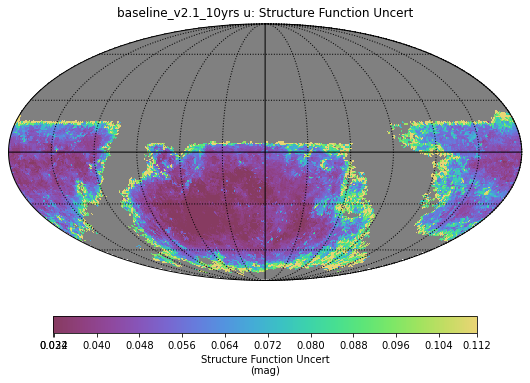

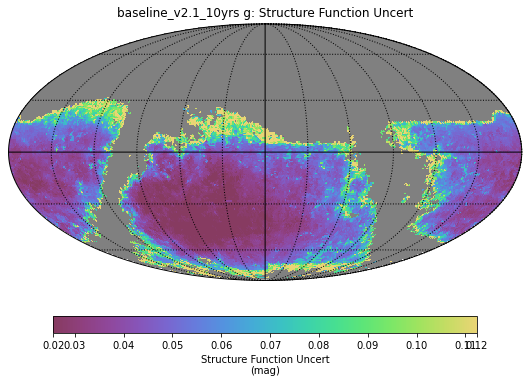

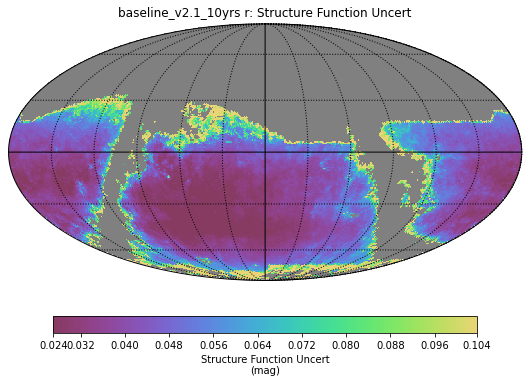

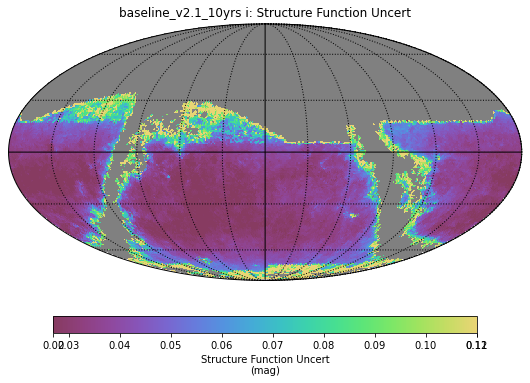

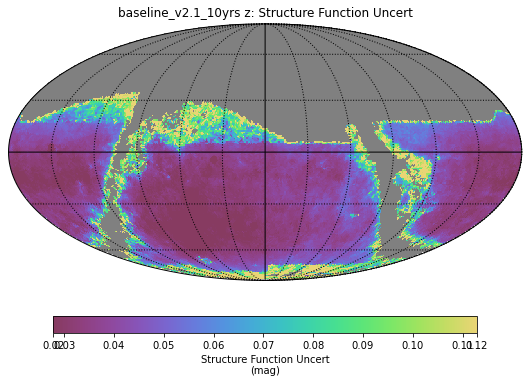

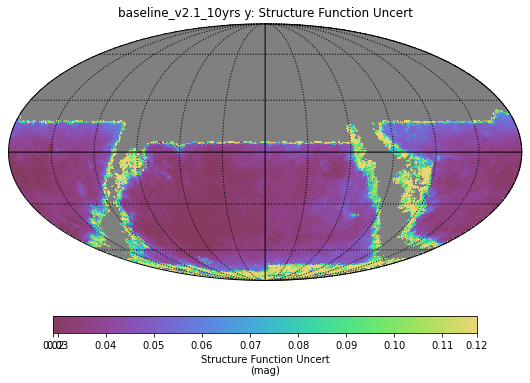

In [14]:
ph = maf.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for f in sf_error:
    ph.setMetricBundles([sf_error[f]])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,5), 'percentileClip': 90})

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 204 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 263 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 250 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 239 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 270 bins, returning 200
  warnings.warn(


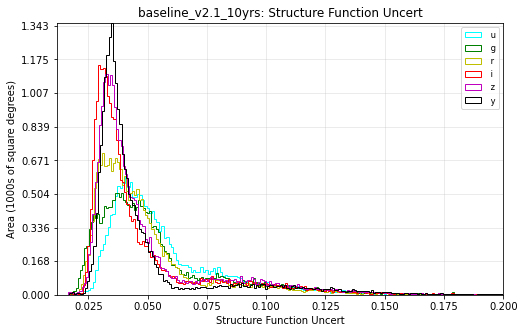

In [15]:
ph.setMetricBundles(sf_error)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,5), 'xMax': 0.2,})
plt.grid(True, alpha=0.3)

In [16]:
# SF Error summary values per band
pd.DataFrame([sf_error[f].summaryValues for f in filterlist], index=filterlist)

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
u,0.058044,0.027361,0.049705,0.347890,0.020727,364,0,21845,0.040389,0.066643
g,0.053740,0.029002,0.045596,0.366053,0.017820,451,0,25470,0.035290,0.060440
r,0.049347,0.025617,0.041937,0.375731,0.020095,578,0,27205,0.033599,0.053905
i,0.048144,0.028712,0.037025,0.336339,0.017324,610,0,28727,0.031307,0.050831
z,0.050269,0.028761,0.039135,0.323690,0.016624,612,0,29704,0.033063,0.052961
y,0.048869,0.028862,0.038001,0.277615,0.017054,708,0,27017,0.033543,0.048026


Given that we do also care about how much of the sky the AGN structure function error is below a given threshhold,  we can add another summary statistic, now we know a reasonable value to set as the threshold.

In [17]:
threshold = 0.04
metric = maf.AreaThresholdMetric(upper_threshold=threshold)

for f in sf_error:
    sf_error[f].setSummaryMetrics([metric])
    sf_error[f].computeSummaryStats()

In [18]:
pd.DataFrame([sf_error[f].summaryValues for f in filterlist], index=filterlist)

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile,AreaThreshold
u,0.058044,0.027361,0.049705,0.347890,0.020727,364,0,21845,0.040389,0.066643,4337.469558
g,0.053740,0.029002,0.045596,0.366053,0.017820,451,0,25470,0.035290,0.060440,7918.735543
r,0.049347,0.025617,0.041937,0.375731,0.020095,578,0,27205,0.033599,0.053905,10239.382472
i,0.048144,0.028712,0.037025,0.336339,0.017324,610,0,28727,0.031307,0.050831,14123.633462
z,0.050269,0.028761,0.039135,0.323690,0.016624,612,0,29704,0.033063,0.052961,13107.248857
y,0.048869,0.028862,0.038001,0.277615,0.017054,708,0,27017,0.033543,0.048026,13057.730532


We can also pull in the summary CSV file, which contains the results of running this on the v2.0 and v2.1 runs. (available sometime later than the metric was contributed). 

In [19]:
# Variance across (most of) current set of simulations?
summaries = maf.get_metric_summaries()
families = maf.get_family_descriptions()

In [28]:
metrics = []
for f in 'ugrizy':
    metrics += [m for m in summaries if 'AGN SF' in m and 'Median' in m and f"{f} band" in m]
for f in 'ugrizy':
    metrics += [m for m in summaries if 'AGN SF' in m and 'Area' in m and f"{f} band" in m]
short_names = [m.replace(' HealpixSlicer', '') for m in metrics]
styles = ['c-', 'g-', 'y-', 'r-', 'm-', 'k-'] + ['c:', 'g:', 'y:', 'r:', 'm:', 'k:']
invert = [True]*6 + [False]*6
mset = maf.create_metric_set_df('AGN SF', metrics, short_names, styles, invert=invert)
mset

metric  \
metric set metric                                                                                               
AGN SF     Median AGN SF_uncert u band HealpixSlicer                Median AGN SF_uncert u band HealpixSlicer   
           Median AGN SF_uncert g band HealpixSlicer                Median AGN SF_uncert g band HealpixSlicer   
           Median AGN SF_uncert r band HealpixSlicer                Median AGN SF_uncert r band HealpixSlicer   
           Median AGN SF_uncert i band HealpixSlicer                Median AGN SF_uncert i band HealpixSlicer   
           Median AGN SF_uncert z band HealpixSlicer                Median AGN SF_uncert z band HealpixSlicer   
           Median AGN SF_uncert y band HealpixSlicer                Median AGN SF_uncert y band HealpixSlicer   
           AreaThreshold AGN SF_uncert u band HealpixSlicer  AreaThreshold AGN SF_uncert u band HealpixSlicer   
           AreaThreshold AGN SF_uncert g band HealpixSlicer  AreaThreshold AGN SF_uncert g band HealpixSlicer   
           AreaThreshold AGN SF_uncert r band HealpixSlicer  AreaThreshold AGN SF_uncert r band HealpixSlicer   
           AreaThreshold AGN SF_uncert i band HealpixSlicer  AreaThreshold AGN SF_uncert i band HealpixSlicer   
           AreaThreshold AGN SF_uncert z band HealpixSlicer  AreaThreshold AGN SF_uncert z band HealpixSlicer   
           AreaThreshold AGN SF_uncert y band HealpixSlicer  AreaThreshold AGN SF_uncert y band HealpixSlicer   

                                                                                     short_name  \
metric set metric                                                                                 
AGN SF     Median AGN SF_uncert u band HealpixSlicer                Median AGN SF_uncert u band   
           Median AGN SF_uncert g band HealpixSlicer                Median AGN SF_uncert g band   
           Median AGN SF_uncert r band HealpixSlicer                Median AGN SF_uncert r band   
           Median AGN SF_uncert i band HealpixSlicer                Median AGN SF_uncert i band   
           Median AGN SF_uncert z band HealpixSlicer                Median AGN SF_uncert z band   
           Median AGN SF_uncert y band HealpixSlicer                Median AGN SF_uncert y band   
           AreaThreshold AGN SF_uncert u band HealpixSlicer  AreaThreshold AGN SF_uncert u band   
           AreaThreshold AGN SF_uncert g band HealpixSlicer  AreaThreshold AGN SF_uncert g band   
           AreaThreshold AGN SF_uncert r band HealpixSlicer  AreaThreshold AGN SF_uncert r band   
           AreaThreshold AGN SF_uncert i band HealpixSlicer  AreaThreshold AGN SF_uncert i band   
           AreaThreshold AGN SF_uncert z band HealpixSlicer  AreaThreshold AGN SF_uncert z band   
           AreaThreshold AGN SF_uncert y band HealpixSlicer  AreaThreshold AGN SF_uncert y band   

                                                            style  invert  \
metric set metric                                                           
AGN SF     Median AGN SF_uncert u band HealpixSlicer           c-    True   
           Median AGN SF_uncert g band HealpixSlicer           g-    True   
           Median AGN SF_uncert r band HealpixSlicer           y-    True   
           Median AGN SF_uncert i band HealpixSlicer           r-    True   
           Median AGN SF_uncert z band HealpixSlicer           m-    True   
           Median AGN SF_uncert y band HealpixSlicer           k-    True   
           AreaThreshold AGN SF_uncert u band HealpixSlicer    c:   False   
           AreaThreshold AGN SF_uncert g band HealpixSlicer    g:   False   
           AreaThreshold AGN SF_uncert r band HealpixSlicer    y:   False   
           AreaThreshold AGN SF_uncert i band HealpixSlicer    r:   False   
           AreaThreshold AGN SF_uncert z band HealpixSlicer    m:   False   
           AreaThreshold AGN SF_uncert y band HealpixSlicer    k:   False   

                                                      

In [29]:
fams = [f for f in families.index if not f.startswith('ddf')]
runs = families.explode(['run']).loc[fams]['run']

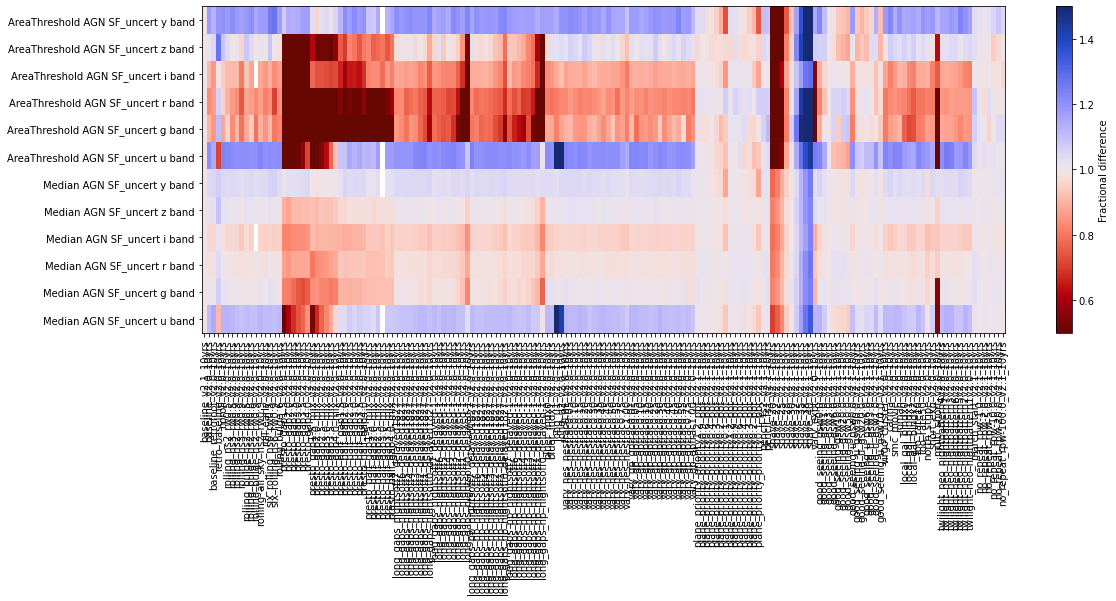

In [32]:
# Plot the *normalized* values
k = 'AGN SF'
fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, mset.loc[k]['metric']], 
                                   baseline_run='baseline_v2.1_10yrs',
                                  color_range=1,
                                   metric_label_map=mset.loc[k]['short_name'],
                                  metric_set=mset.loc[k])
fig.set_figwidth(18)

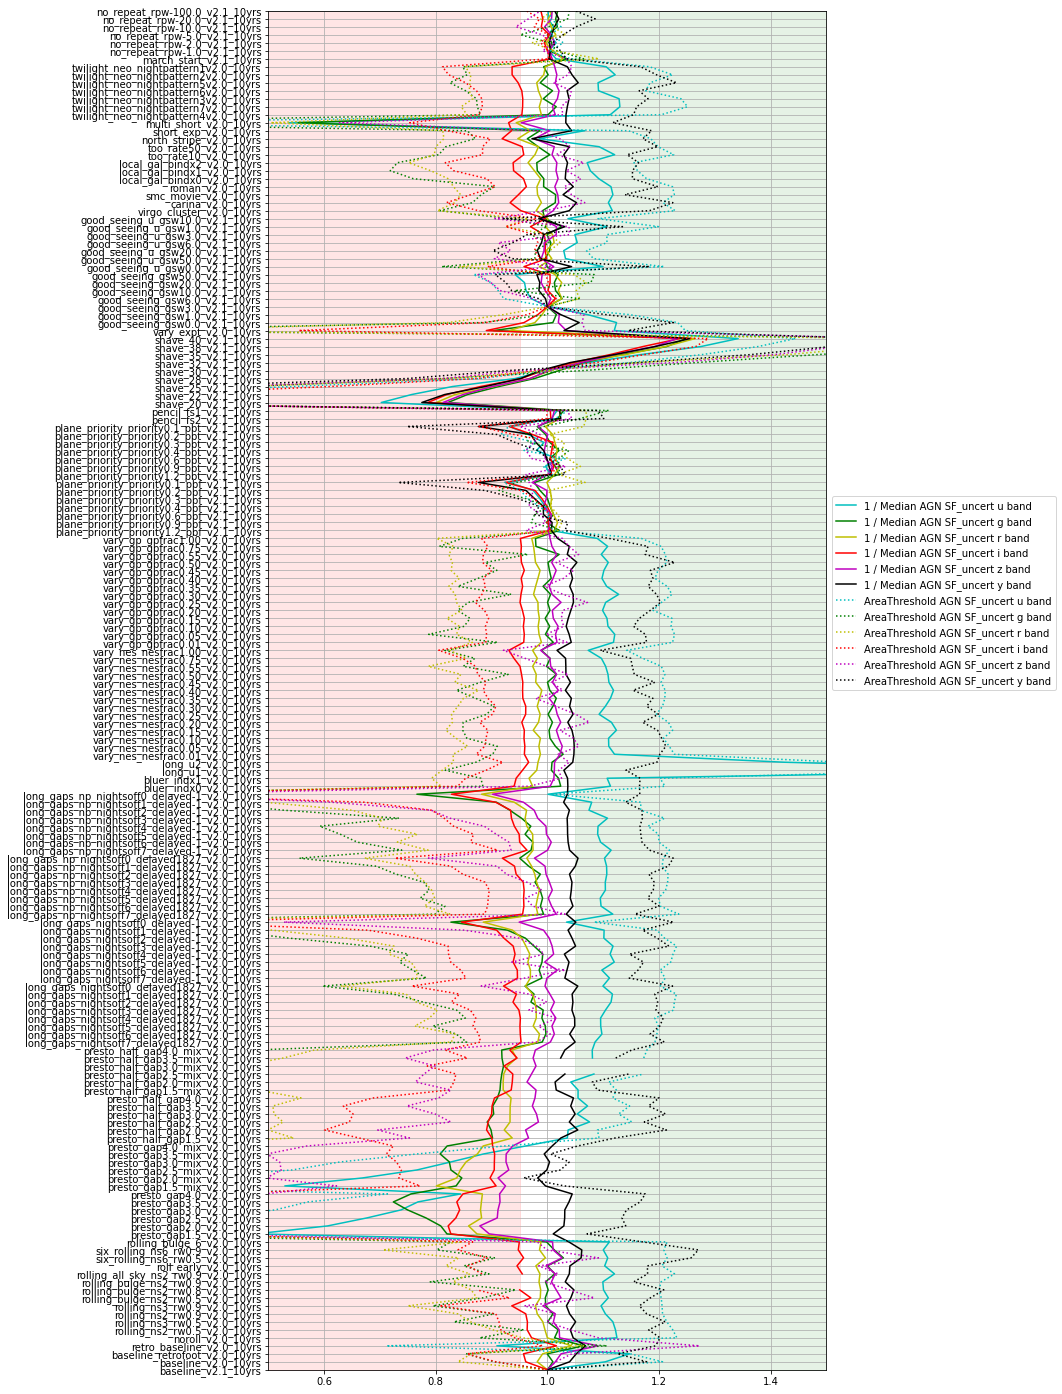

In [33]:
# Plot the normalized values, in a different way
fig, ax = maf.plot_run_metric(summaries.loc[runs, mset.loc[k]['metric']],
                             baseline_run='baseline_v2.1_10yrs',
                             metric_label_map=mset.loc[k]['short_name'],
                             metric_set=mset.loc[k],
                             horizontal_quantity='value',
                             vertical_quantity='run')
fig.set_figheight(25)
ax.set_xlim(0.5, 1.5)
ax.legend(loc=(1.01, 0.5))